# The Residual Neural Network implmenting in Tensorflow / Keras
### Data from : Intel Image Classification

In [1]:
# Import Necessary Libraries

from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2


print(tf.__version__)

2.6.0


# Comfirming Tensorflow is using GPU


The tensorflow APIs about testing whether the GPU is functioning are as follow :

- **The Python Code**

```python
  if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

  else:
    print("Please install GPU version of TF")
```


- **output** 

 Default GPU Device:/device:GPU:0

In [2]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


# List the Categories of the datasets

We will utilize the `os.listdir(path = datasets' path)` to help us identify the class

In [3]:
# Categories
classes = os.listdir(path = 'archive/seg_train/seg_train')
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


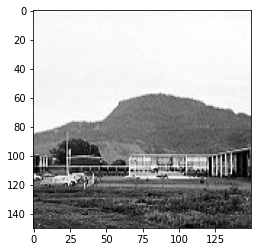

In [4]:
path_train = 'archive/seg_train/seg_train'
path_test = 'archive/seg_test/seg_test'


for category in classes:
    path = os.path.join(path_train, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap = "gray")
        plt.show()
        break
    break

In [5]:
print(img_array.shape)

(150, 150)


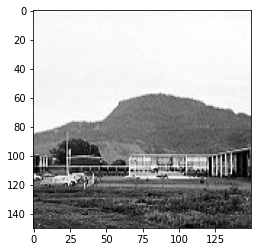

In [6]:
IMG_SIZE = 150

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.show()

In [7]:
training_data = []
testing_data = []

def create_training_data():
    for category in classes:
        path = os.path.join(path_train, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
            
def create_testing_data():
    for category in classes:
        path = os.path.join(path_test, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                testing_data.append([new_array, class_num])
            except Exception as e:
                pass
            

create_training_data()
create_testing_data()

In [8]:
import random

random.shuffle(training_data)
random.shuffle(testing_data)

for sample in training_data[:10]:
    print(sample[1])
    
for sample in testing_data[:10]:
    print(sample[1])

4
3
2
4
2
5
0
1
0
0
2
0
5
0
2
2
3
5
0
3


In [9]:
test_images = []
test_labels = []
train_images = []
train_labels = []

In [10]:
for features, label in training_data:
    train_images.append(features)
    train_labels.append(label)
    
for features, label in testing_data:
    test_images.append(features)
    test_labels.append(label)
    

train_images = np.array(train_images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
train_labels = np.array(train_labels)

test_images = np.array(test_images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_labels = np.array(test_labels)

In [11]:
print(train_images.shape)
print(train_labels.shape)

print(test_images.shape)
print(test_labels.shape)

(14034, 150, 150, 1)
(14034,)
(3000, 150, 150, 1)
(3000,)


In [12]:
from tensorflow.keras import backend as K
import tensorflow as tf
K.clear_session()

## Model

Let's build a resnet model with Keras and train it.

We will be using two kinds of residual blocks:

    - Identity Block
    - Convolution Block

#### Identity Block

In the *identity block* we have a skip connection with no change in input, paired with a standard set of convolutional layers. 

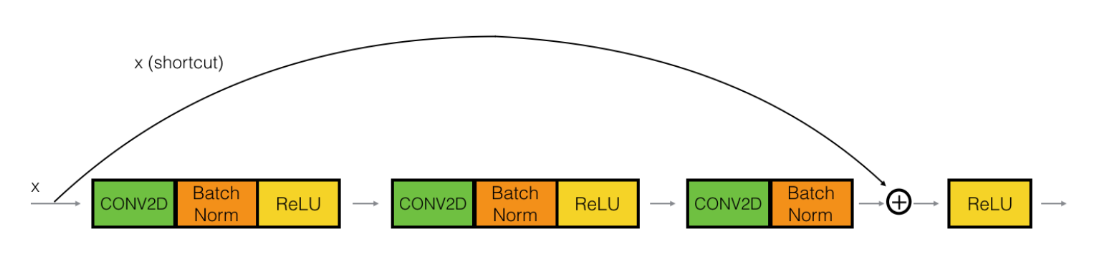


#### Convolution Block

The convolution block is very similar to the identity block, but there is a convolutional layer in the skip-connection path just to change the dimension such that the dimension of the input and output matches.

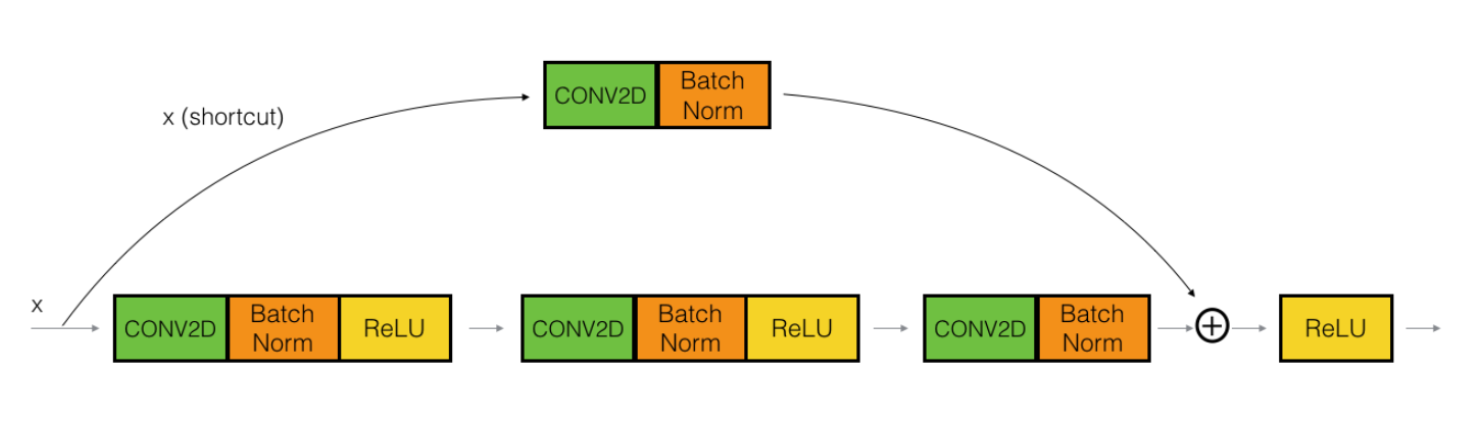

Let's start building the identity block: 

In [13]:
def identity_block(X, f, filters, stage, block):
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve filters
    F1, F2, F3 = filters
    
    # A path is a block of conv followed by batch normalization and activation
    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [14]:
def convolutional_block(X, f, filters, stage, block, s=2):

    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

# Starting to build Residual Neural Network

In [15]:
def ResNet(input_shape = (IMG_SIZE, IMG_SIZE, 1), classes = len(classes)):

    # Define the input as a tensor with shape input_shape
    X_input = Input(shape=input_shape)


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet')

    return model

In [16]:
model = ResNet(input_shape = (IMG_SIZE, IMG_SIZE, 1), classes = len(classes))

# Take a look at the model summary
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
_____________________________________________________________________________________________

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'MeanSquaredError'])

In [ ]:
from time import time

original_time = time()
history = model.fit(train_images, 
                    train_labels,
                    batch_size=64,
                    epochs=100,
                    validation_split = 0.15)


print("\n\n\nCalculating time : ", time()-original_time)
print(history.history.keys())

Epoch 1/100
187/187 [==============================] - 48s 185ms/step - loss: 4.5156 - accuracy: 0.5203 - mean_squared_error: 8.5527 - val_loss: 1.4992 - val_accuracy: 0.5033 - val_mean_squared_error: 8.5764
Epoch 2/100
187/187 [==============================] - 33s 174ms/step - loss: 0.9192 - accuracy: 0.6999 - mean_squared_error: 8.5519 - val_loss: 1.7556 - val_accuracy: 0.5147 - val_mean_squared_error: 8.6122
Epoch 3/100
187/187 [==============================] - 33s 178ms/step - loss: 0.6540 - accuracy: 0.7616 - mean_squared_error: 8.5573 - val_loss: 0.8071 - val_accuracy: 0.7213 - val_mean_squared_error: 8.5996
Epoch 4/100
187/187 [==============================] - 34s 184ms/step - loss: 0.5580 - accuracy: 0.7963 - mean_squared_error: 8.5607 - val_loss: 2.3251 - val_accuracy: 0.4981 - val_mean_squared_error: 8.6167
Epoch 5/100
187/187 [==============================] - 36s 192ms/step - loss: 0.4740 - accuracy: 0.8287 - mean_squared_error: 8.5656 - val_loss: 2.2079 - val_accuracy: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model train accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'test accuracy'], loc = 'upper right')
plt.show()

In [ ]:
# Evaluating the model using the test set
loss, accuracy, MSE = model.evaluate(test_images, test_labels, verbose = 1)
print('\nTest accuracy:', accuracy)

In [ ]:
# Making predictions from the test_images

predictions = model.predict(test_images)

In [ ]:
# Reshape input data from (IMG_SIZE, IMG_SIZE) to (IMG_SIZE, IMG_SIZE, 1)
w, h = IMG_SIZE, IMG_SIZE
train_images = train_images.reshape(train_images.shape[0], w, h)
test_images = test_images.reshape(test_images.shape[0], w, h)


# Helper functions to plot images 
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classes[predicted_label],
                                100*np.max(predictions_array),
                                classes[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(6))
  plt.yticks([])
  thisplot = plt.bar(range(6), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()